In [1]:
#pip install opencv-python
#pip install scikit-image

In [84]:
import numpy as np
import pandas as pd
import gzip
import cv2
import tensorflow as tf
import keras
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from tensorflow.keras import layers 
from keras.layers import Dense, GlobalAveragePooling2D
from keras.initializers import RandomNormal
from keras.optimizers import SGD

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("data/train.csv")

In [4]:
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


In [6]:
df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [7]:
for c in df.columns:
    print ("---- %s ----" % c)
    print (df[c].value_counts())
    print("\n")

---- Id ----
7473a90c0f7b640d3cb80f14b6a7bf9e    1
9c5867e1c5968f27e99ca05f55135818    1
e7bdb0f023795cbb2d1e237e49982298    1
996a2123efa0aa6df96d14bb767e77bd    1
68a0dc40fbab9a54b61adb3c8bd4edd5    1
                                   ..
934333e4225606d562bce5061d10dcb3    1
a858b80acb6fbbd0b03e9bb7539234c4    1
b18e40e5bdbdefc3c157b445735fab36    1
94c823294d542af6e660423f0348bf31    1
ac877d2e9d2be54570888dfd3e724103    1
Name: Id, Length: 9912, dtype: int64


---- Subject Focus ----
0    9638
1     274
Name: Subject Focus, dtype: int64


---- Eyes ----
1    7658
0    2254
Name: Eyes, dtype: int64


---- Face ----
1    8960
0     952
Name: Face, dtype: int64


---- Near ----
1    8540
0    1372
Name: Near, dtype: int64


---- Action ----
0    9813
1      99
Name: Action, dtype: int64


---- Accessory ----
0    9240
1     672
Name: Accessory, dtype: int64


---- Group ----
0    8630
1    1282
Name: Group, dtype: int64


---- Collage ----
0    9420
1     492
Name: Collage, dtype: in

In [8]:
# Count of null values per column & total
display(df.isna().sum())
print('Total Null Count:', df.isna().sum().sum())

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64

Total Null Count: 0


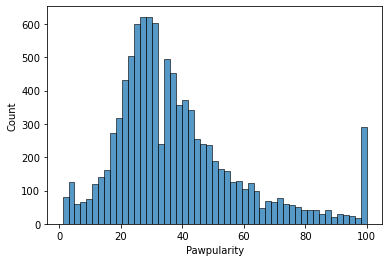

In [81]:
sns.histplot(df['Pawpularity']);

In [12]:
images = []
count = 0
for index in range(len(df)):
    Id = df.loc[index, 'Id']
    path = 'data/train/'+str(Id)+'.jpg'
    img_array = cv2.imread(path)
    img_array = resize(img_array, (64, 64), anti_aliasing=True)
    images.append(img_array)
    count += 1
    progress = (count/len(df))*100
    print('progress =', round(progress,2), '%', end='\r')

In [65]:
angusdf = pd.read_csv("data/angus.csv")

In [72]:
angusimages = []
count = 0
for index in range(len(angusdf)):
    Id = angusdf.loc[index, 'Id']
    path = 'data/angus/'+str(Id)+'.jpg'
    img_array = cv2.imread(path)
    img_array = resize(img_array, (64, 64), anti_aliasing=True)
    angusimages.append(img_array)
    count += 1
    progress = (count/len(df))*100
    print('progress =', round(progress,2), '%', end='\r')

In [73]:
Angus = (np.array(angusimages)/255)

In [52]:
df.shape[0]

9912

In [53]:
len(df)

9912

In [55]:
X=(np.array(images)/255)

KeyboardInterrupt: 

In [54]:
X.shape

(9912, 64, 64, 3)

In [18]:
y = df['Pawpularity']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [147]:
def model_eval(model, X_train, y_train, X_test, y_test):
    
    # calculate training data metrics
    train_eval = model.evaluate(X_train, y_train)
    
    # calculate test data metrics
    test_eval = model.evaluate(X_test, y_test)
    
    # print metrics
    print(f"""
    {model} Training Metrics:
    Loss: {round(train_eval[0] , 3)}
    Root Mean Square Error: {round(train_eval[1] , 3)}
    ------
    {model} Test Metrics:
    Loss: {round(test_eval[0] , 3)}
    Root Mean Square Error: {round(test_eval[1] , 3)}
    """)

In [37]:
ann = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(10, activation='softmax')
      ])

ann.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

ann.fit(X_train, y_train, epochs=5)

Epoch 1/5
233/233 [==============================] - 95s 408ms/step - loss: 1854.0858 - root_mean_squared_error: 43.0591
Epoch 2/5
233/233 [==============================] - 88s 377ms/step - loss: 1854.0845 - root_mean_squared_error: 43.0591
Epoch 3/5
233/233 [==============================] - 88s 380ms/step - loss: 1854.0863 - root_mean_squared_error: 43.0591
Epoch 4/5
233/233 [==============================] - 98s 423ms/step - loss: 1854.0857 - root_mean_squared_error: 43.0591
Epoch 5/5
233/233 [==============================] - 97s 418ms/step - loss: 1854.0856 - root_mean_squared_error: 43.0591


In [148]:
model_eval(ann, X_train, y_train, X_test, y_test)

78/78 [==============================] - 8s 100ms/step - loss: 1891.1780 - root_mean_squared_error: 43.4877

    <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000199476978E0> Training Metrics:
    Loss: 1854.086
    Root Mean Square Error: 43.059
    ------
    <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000199476978E0> Test Metrics:
    Loss: 1891.178
    Root Mean Square Error: 43.488
    


In [150]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'root_mean_squared_error'])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [162]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error'])


In [165]:
history.history['root_mean_squared_error']

[27.64341163635254,
 21.727224349975586,
 21.614442825317383,
 21.524890899658203,
 21.419546127319336,
 21.332698822021484,
 21.23833465576172,
 21.15863609313965,
 21.064817428588867,
 20.98931884765625]

In [33]:
ann_results_train = ann.evaluate(X_train, y_train)
ann_results_train

233/233 [==============================] - 25s 106ms/step - loss: 1854.0861 - root_mean_squared_error: 43.0591


[1854.0860595703125, 43.059078216552734]

In [90]:
ann_results_test = ann.evaluate(X_test, y_test)
ann_results_test

78/78 [==============================] - 8s 105ms/step - loss: 1891.1780 - root_mean_squared_error: 43.4877


1891.177978515625

In [126]:
basemodel = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(units=1, activation=None)
])

basemodel.compile(optimizer='adam',
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

basemodel.fit(X_train,y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 1s 5ms/step - loss: 1666.2449 - root_mean_squared_error: 40.8197
Epoch 2/10
233/233 [==============================] - 1s 4ms/step - loss: 1328.6251 - root_mean_squared_error: 36.4503
Epoch 3/10
233/233 [==============================] - 1s 5ms/step - loss: 1068.1133 - root_mean_squared_error: 32.6820
Epoch 4/10
233/233 [==============================] - 1s 4ms/step - loss: 873.0610 - root_mean_squared_error: 29.5476
Epoch 5/10
233/233 [==============================] - 1s 4ms/step - loss: 731.9345 - root_mean_squared_error: 27.0543
Epoch 6/10
233/233 [==============================] - 1s 5ms/step - loss: 633.2869 - root_mean_squared_error: 25.1652
Epoch 7/10
233/233 [==============================] - 1s 5ms/step - loss: 567.4288 - root_mean_squared_error: 23.8208
Epoch 8/10
233/233 [==============================] - 1s 5ms/step - loss: 525.7422 - root_mean_squared_error: 22.9291
Epoch 9/10
233/233 [==============================] -

In [125]:
baseline_results_train = basemodel.evaluate(X_train, y_train)
baseline_results_train

233/233 [==============================] - 1s 4ms/step - loss: 464.1647 - root_mean_squared_error: 21.5445


[464.1646728515625, 21.54448127746582]

In [99]:
baseline_results_test = basemodel.evaluate(X_test, y_test)
baseline_results_test

78/78 [==============================] - 0s 5ms/step - loss: 506.6156 - root_mean_squared_error: 22.5081


[506.6155700683594, 22.508121490478516]

In [100]:
basemodel.predict(Angus)

array([[50.560146],
       [45.98768 ],
       [30.489588],
       [35.786816],
       [29.730162],
       [29.589037],
       [32.022743]], dtype=float32)

In [101]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation=None)
])

model1.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model1.fit(X_train,y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 6s 25ms/step - loss: 760.2005 - root_mean_squared_error: 27.5717
Epoch 2/10
233/233 [==============================] - 5s 23ms/step - loss: 471.9139 - root_mean_squared_error: 21.7236
Epoch 3/10
233/233 [==============================] - 5s 23ms/step - loss: 466.7472 - root_mean_squared_error: 21.6043
Epoch 4/10
233/233 [==============================] - 5s 23ms/step - loss: 462.8084 - root_mean_squared_error: 21.5130
Epoch 5/10
233/233 [==============================] - 5s 24ms/step - loss: 458.0831 - root_mean_squared_error: 21.4029
Epoch 6/10
233/233 [==============================] - 6s 25ms/step - loss: 454.4273 - root_mean_squared_error: 21.3173
Epoch 7/10
233/233 [==============================] - 5s 23ms/step - loss: 450.8512 - root_mean_squared_error: 21.2333
Epoch 8/10
233/233 [==============================] - 5s 22ms/step - loss: 446.4073 - root_mean_squared_error: 21.1284
Epoch 9/10
233/233 [============================

In [102]:
model1_results_train = model1.evaluate(X_train, y_train)
model1_results_train

233/233 [==============================] - 2s 8ms/step - loss: 437.4350 - root_mean_squared_error: 20.9149


[437.4350280761719, 20.914947509765625]

In [103]:
model1_results_test = model1.evaluate(X_test, y_test)
model1_results_test

78/78 [==============================] - 1s 8ms/step - loss: 466.6355 - root_mean_squared_error: 21.6017


[466.6355285644531, 21.601747512817383]

In [104]:
model1.predict(Angus)

array([[49.027485],
       [44.889626],
       [38.757145],
       [42.81725 ],
       [31.706997],
       [33.819065],
       [36.058857]], dtype=float32)

In [105]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='relu')
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model2.fit(X_train,y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 5s 23ms/step - loss: 725.5312 - root_mean_squared_error: 26.9357
Epoch 2/10
233/233 [==============================] - 5s 23ms/step - loss: 471.6515 - root_mean_squared_error: 21.7175
Epoch 3/10
233/233 [==============================] - 6s 25ms/step - loss: 466.5613 - root_mean_squared_error: 21.6000
Epoch 4/10
233/233 [==============================] - 6s 26ms/step - loss: 461.8459 - root_mean_squared_error: 21.4906
Epoch 5/10
233/233 [==============================] - 6s 26ms/step - loss: 457.4921 - root_mean_squared_error: 21.3891
Epoch 6/10
233/233 [==============================] - 5s 23ms/step - loss: 453.3649 - root_mean_squared_error: 21.2924
Epoch 7/10
233/233 [==============================] - 5s 22ms/step - loss: 449.1742 - root_mean_squared_error: 21.1937 1s - loss: 4 - ETA: 0s - loss: 453.6304 - root_mean_
Epoch 8/10
233/233 [==============================] - 5s 22ms/step - loss: 445.6708 - root_mean_squared_error: 21.

In [106]:
model2_results_train = model2.evaluate(X_train, y_train)
model2_results_train

233/233 [==============================] - 2s 9ms/step - loss: 437.3018 - root_mean_squared_error: 20.9118


[437.3017883300781, 20.911762237548828]

In [107]:
model2_results_test = model2.evaluate(X_test, y_test)
model2_results_test

78/78 [==============================] - 1s 10ms/step - loss: 465.1524 - root_mean_squared_error: 21.5674


[465.15240478515625, 21.567392349243164]

In [108]:
model2.predict(Angus)

array([[51.827145],
       [47.452126],
       [40.70962 ],
       [45.04008 ],
       [33.839874],
       [35.918907],
       [38.176846]], dtype=float32)

In [110]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='relu')
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model3.fit(X_train,y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 7s 29ms/step - loss: 687.4943 - root_mean_squared_error: 26.2201
Epoch 2/10
233/233 [==============================] - 7s 31ms/step - loss: 465.6230 - root_mean_squared_error: 21.5783
Epoch 3/10
233/233 [==============================] - 7s 29ms/step - loss: 456.2186 - root_mean_squared_error: 21.3593
Epoch 4/10
233/233 [==============================] - 6s 27ms/step - loss: 449.6800 - root_mean_squared_error: 21.2057
Epoch 5/10
233/233 [==============================] - 8s 33ms/step - loss: 442.2668 - root_mean_squared_error: 21.0301 0s - loss: 442.0395 - root_mean_squared_error: 21.02 - ETA: 0s - loss: 440.6403 - root_mean_squared_er
Epoch 6/10
233/233 [==============================] - 6s 27ms/step - loss: 434.9645 - root_mean_squared_error: 20.8558
Epoch 7/10
233/233 [==============================] - 6s 26ms/step - loss: 429.4001 - root_mean_squared_error: 20.7220
Epoch 8/10
233/233 [==============================] - 6s 25ms/st

In [111]:
model3_results_train = model3.evaluate(X_train, y_train)
model3_results_train

233/233 [==============================] - 2s 11ms/step - loss: 421.1823 - root_mean_squared_error: 20.5227


[421.1822509765625, 20.52272605895996]

In [112]:
model3_results_test = model3.evaluate(X_test, y_test)
model3_results_test

78/78 [==============================] - 1s 15ms/step - loss: 454.3867 - root_mean_squared_error: 21.3163


[454.3866882324219, 21.316347122192383]

In [113]:
model3.predict(Angus)

array([[45.249004],
       [43.734444],
       [42.45512 ],
       [45.328007],
       [37.970776],
       [40.79989 ],
       [39.10857 ]], dtype=float32)

In [127]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])
model4.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model4.fit(X_train,y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 44s 191ms/step - loss: 584.9793 - root_mean_squared_error: 24.1863
Epoch 2/10
233/233 [==============================] - 47s 201ms/step - loss: 431.9220 - root_mean_squared_error: 20.7827
Epoch 3/10
233/233 [==============================] - 42s 179ms/step - loss: 428.2815 - root_mean_squared_error: 20.6950
Epoch 4/10
233/233 [==============================] - 38s 162ms/step - loss: 427.8236 - root_mean_squared_error: 20.6839
Epoch 5/10
233/233 [==============================] - 40s 172ms/step - loss: 425.8780 - root_mean_squared_error: 20.6368
Epoch 6/10
233/233 [==============================] - 42s 181ms/step - loss: 421.8957 - root_mean_squared_error: 20.5401
Epoch 7/10
233/233 [==============================] - 38s 162ms/step - loss: 425.4417 - root_mean_squared_error: 20.6262
Epoch 8/10
233/233 [==============================] - 42s 179ms/step - loss: 431.7321 - root_mean_squared_error: 20.7782
Epoch 9/10
233/233 [============

In [128]:
model4_results_train = model4.evaluate(X_train, y_train)
model4_results_train

233/233 [==============================] - 12s 52ms/step - loss: 427.7314 - root_mean_squared_error: 20.6817


[427.7314453125, 20.681669235229492]

In [129]:
model4_results_test = model4.evaluate(X_test, y_test)
model4_results_test

78/78 [==============================] - 4s 47ms/step - loss: 453.6400 - root_mean_squared_error: 21.2988


[453.6400451660156, 21.298828125]

In [130]:
model4.predict(Angus)

array([[41.826263],
       [41.63789 ],
       [41.448685],
       [41.55911 ],
       [41.10739 ],
       [41.147514],
       [41.286156]], dtype=float32)

In [21]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='linear'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [23]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
233/233 [==============================] - 125s 535ms/step - loss: 438.2681 - root_mean_squared_error: 20.9349
Epoch 2/10
233/233 [==============================] - 119s 512ms/step - loss: 435.3079 - root_mean_squared_error: 20.8640
Epoch 3/10
233/233 [==============================] - 118s 506ms/step - loss: 429.2565 - root_mean_squared_error: 20.7185
Epoch 4/10
233/233 [==============================] - 115s 495ms/step - loss: 430.1349 - root_mean_squared_error: 20.7397
Epoch 5/10
233/233 [==============================] - 118s 505ms/step - loss: 429.7290 - root_mean_squared_error: 20.7299
Epoch 6/10
233/233 [==============================] - 118s 509ms/step - loss: 431.8163 - root_mean_squared_error: 20.7802
Epoch 7/10
233/233 [==============================] - 121s 518ms/step - loss: 433.9294 - root_mean_squared_error: 20.8310
Epoch 8/10
233/233 [==============================] - 118s 506ms/step - loss: 426.4255 - root_mean_squared_error: 20.6501
Epoch 9/10
233/233 [====

In [24]:
model_results_train = model.evaluate(X_train, y_train)
model_results_train

233/233 [==============================] - 25s 108ms/step - loss: 443.0788 - root_mean_squared_error: 21.0494


[443.07879638671875, 21.049436569213867]

In [25]:
model_results_test = model.evaluate(X_test, y_test)
model_results_test

78/78 [==============================] - 9s 121ms/step - loss: 471.4400 - root_mean_squared_error: 21.7127


[471.4399719238281, 21.712669372558594]

In [77]:
model.predict(Angus)

array([[33.442947],
       [33.216103],
       [32.94802 ],
       [33.19907 ],
       [32.68118 ],
       [32.85116 ],
       [32.797844]], dtype=float32)

In [85]:
model2 = tf.keras.Sequential([    
            keras.Input(shape=(64,64,3)),
            keras.layers.Conv2D(filters = 16, kernel_size=[5,5], activation = 'relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters = 32, kernel_size=[5,5], activation = 'relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.25),
            keras.layers.Conv2D(filters = 64, kernel_size=[3,3],  activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),  activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation = "relu"),
            tf.keras.layers.Dense(128, activation = "relu"),
            tf.keras.layers.Dense(64, activation = "relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1)])
    
model2.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model2.fit(X_train, y_train, epochs=5)

Epoch 1/5
233/233 [==============================] - 551s 2s/step - loss: 635.7822 - root_mean_squared_error: 25.2147
Epoch 2/5
233/233 [==============================] - 568s 2s/step - loss: 556.9897 - root_mean_squared_error: 23.6006
Epoch 3/5
233/233 [==============================] - 555s 2s/step - loss: 506.2378 - root_mean_squared_error: 22.4997
Epoch 4/5
233/233 [==============================] - 563s 2s/step - loss: 465.9215 - root_mean_squared_error: 21.5852
Epoch 5/5
233/233 [==============================] - 548s 2s/step - loss: 443.7258 - root_mean_squared_error: 21.0648
